# VAE Version (AI Lab Run)
- V2: inheriting from A-V10, that we have attention module, as well as biLSTM. Now we also add VAE. 
- V4: VQ-VAE. NOTICE that VQVAE is not a real VAE, but AE in essense. So we will return to the old AE structure. 

## Preparing

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from model_model import VQVAEV1 as TheLearner
from model_dataset import DS_Tools
from model_dataset import WordDataset as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
# from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import MelSpecTransformDB as TheTransform
from paths import *
from misc_my_utils import *
from misc_recorder import *
from model_loss import *
from model_padding import generate_mask_from_lengths_mat

### Dirs

In [3]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [14]:
BATCH_SIZE = 512

INPUT_DIM = 64
OUTPUT_DIM = 64 

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.3
NUM_LAYERS = 3
EMBEDDING_DIM = 64

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 32
# LOADER_WORKER = 0

## Prepare for this time of training

In [26]:
ts = str(get_timestamp())
# ts = "0218230825"
stop_epoch = "29"
train_name = "B_05"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

train_losses = ListRecorder(os.path.join(model_save_dir, "train.loss"))
train_recon_losses = ListRecorder(os.path.join(model_save_dir, "train.recon.loss"))
train_embedding_losses = ListRecorder(os.path.join(model_save_dir, "train.embedding.loss"))
train_commitment_losses = ListRecorder(os.path.join(model_save_dir, "train.commitment.loss"))

valid_losses = ListRecorder(os.path.join(model_save_dir, "valid.loss"))
valid_recon_losses = ListRecorder(os.path.join(model_save_dir, "valid.recon.loss"))
valid_embedding_losses = ListRecorder(os.path.join(model_save_dir, "valid.embedding.loss"))
valid_commitment_losses = ListRecorder(os.path.join(model_save_dir, "valid.commitment.loss"))

text_hist = HistRecorder(os.path.join(model_save_dir, "trainhist.txt"))

B_05-0219170639


- 0217175750: first trial of training. 
- 0217195946: take the opposite of kl to turn it into loss, instead of divergence. [!!! This is wrong]
- 0217200818: add num layers to 3. 
- (B_03) 0217213117: deleted VAE part. 
- (B_04) 0218230825: VQVAE
- (B_05) 0219170639: added relu to VQVAE pre-lstm linear. 

In [27]:
READ = False
DATAREAD = False

In [28]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist = ["BLANK"] + mylist

# Now you can use the loaded object
mymap = TokenMap(mylist)

mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

train_ds = ThisDataset(rec_dir, 
                       train_guide_path, 
                       mapper=mymap, 
                       transform=mytrans)
valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       mapper=mymap, 
                       transform=mytrans)

use_proportion = 0.3

if READ or DATAREAD: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.use"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

    use_train_ds = torch.utils.data.Subset(train_ds, train_ds_indices)
    use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)
else: 
    # train data
    use_len = int(use_proportion * len(train_ds))
    remain_len = len(train_ds) - use_len
    use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

    # valid data
    use_len = int(use_proportion * len(valid_ds))
    remain_len = len(valid_ds) - use_len
    use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.use"), use_train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.use"), use_valid_ds.indices)

train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)

In [29]:
train_num, valid_num, len(train_loader), len(valid_loader)

(231830, 31142, 453, 61)

torch.Size([512, 75, 64])


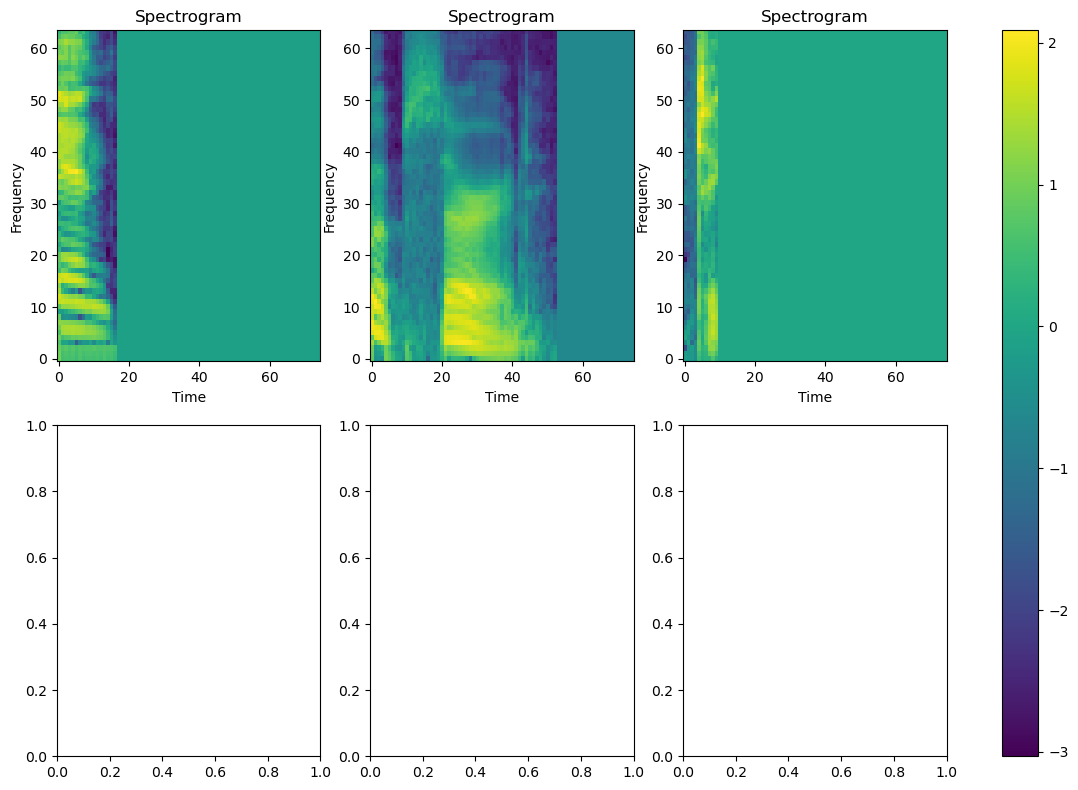

In [30]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
xx_pad, x_lens = sample_data
print(xx_pad.shape)
# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
# random_indices = random.sample(range(len(xx_pad)), 6)
random_indices = list(range(6, 9))

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    
    ax = axes[i]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    ax.set_title(f'Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

# for i, idx in enumerate(random_indices):
#     spectrogram = masked_xx_pad[idx]
    
#     ax = axes[i + 3]
#     img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
#     ax.set_title(f'Spectrogram')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

## Loss
VAE的损失由重构损失和KL损失组成.

KL散度就不再推导了, 直接放结果:
$$KL\Big(N(\mu,\sigma^2)\Big\Vert N(0,1)\Big)=\frac{1}{2}\Big(-\log \sigma^2+\mu^2+\sigma^2-1\Big)$$

VAE的目标是最小化$Z$和$\mathcal{N}(0, I)$之间的KL散度, 代码只需要照着写就行了:

In [31]:
masked_loss = MaskedLoss(loss_fn=nn.MSELoss(reduction="none"))

## Prepare Model
先定义好训练的epoch和batch_size, 优化器随便选一个世界上最好的优化器Adam(lr=1e-3):

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TheLearner(enc_size_list=ENC_SIZE_LIST, 
                   dec_size_list=DEC_SIZE_LIST, 
                   embedding_dim=EMBEDDING_DIM, 
                   num_layers=NUM_LAYERS, dropout=DROPOUT)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [33]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

# initialize model weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.LSTM): 
        for name, p in m.named_parameters():
            if "weight" in name: 
                nn.init.orthogonal_(p)
            elif "bias" in name: 
                nn.init.constant_(p, 0)

model.apply(init_weights)

8688


VQVAEV1(
  (encoder): VQEncoderV1(
    (lin_1): Linear(in_features=64, out_features=8, bias=True)
    (rnn): LSTM(8, 8, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
    (lin_2): Linear(in_features=16, out_features=8, bias=True)
    (act): ReLU()
  )
  (decoder): VQDecoderV1(
    (lin_1): Linear(in_features=64, out_features=8, bias=True)
    (rnn): LSTM(8, 8, num_layers=3, batch_first=True, dropout=0.3)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_2): Linear(in_features=8, out_features=64, bias=True)
    (act): ReLU()
  )
  (vq_embedding): Embedding(64, 8)
)

### Load model if READ

In [35]:
if READ: 
    train_losses.read()
    train_recon_losses.read()
    train_embedding_losses.read()
    train_commitment_losses.read()

    valid_losses.read()
    valid_recon_losses.read()
    valid_embedding_losses.read()
    valid_commitment_losses.read()

    model_name = "{}.pt".format(stop_epoch)
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

## Training

In [36]:
l_w_embedding = 1
l_w_commitment = 0.25

In [37]:
EPOCHS = 50
BASE = 0

In [26]:
for epoch in range(BASE, BASE + EPOCHS):
    text_hist.print("Epoch {}".format(epoch))

    model.train()
    train_loss = 0.
    cumulative_l_reconstruct = 0.
    
    
    train_num = len(train_loader.dataset)    # train_loader
    for idx, (x, x_lens) in enumerate(train_loader):
        current_batch_size = x.shape[0]
        # y_lens should be the same as x_lens
        optimizer.zero_grad()
        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        # autoencoder
        y = x
        x = x.to(device)
        y = y.to(device)

        x_hat, attn_w, (ze, zq) = model(x, x_lens, x_mask)

        l_reconstruct = masked_loss.get_loss(x_hat, y, x_mask)
        l_embedding = masked_loss.get_loss(ze.detach(), zq, x_mask)
        l_commitment = masked_loss.get_loss(ze, zq.detach(), x_mask)
        loss = l_reconstruct + \
            l_w_embedding * l_embedding + l_w_commitment * l_commitment

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
        optimizer.step()

        train_loss += loss.item() * current_batch_size

        if idx % 100 == 0:
            text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

    train_losses.append(train_loss / train_num)
    train_recon_losses.append()


    text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

    last_model_name = "{}.pt".format(epoch)
    torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))


    model.eval()
    valid_loss = 0.
    valid_num = len(valid_loader.dataset)
    for idx, (x, x_lens) in enumerate(valid_loader):
        current_batch_size = x.shape[0]
        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)

        y = x
        x = x.to(device)
        y = y.to(device)

        x_hat, attn_w, (ze, zq) = model(x, x_lens, x_mask)

        l_reconstruct = masked_loss.get_loss(x_hat, y, x_mask)
        l_embedding = masked_loss.get_loss(ze.detach(), zq, x_mask)
        l_commitment = masked_loss.get_loss(ze, zq.detach(), x_mask)
        loss = l_reconstruct + \
            l_w_embedding * l_embedding + l_w_commitment * l_commitment

        valid_loss += loss.item() * current_batch_size

    text_hist.print(f"Valid loss {valid_loss / valid_num: .3f}")
    valid_losses.append(valid_loss / valid_num)

Epoch 50
Training loss  0.700 in Step 0
Training loss  0.689 in Step 100
Training loss  0.705 in Step 200
Training loss  0.712 in Step 300
Training loss  0.699 in Step 400
※※※Training loss  0.707※※※
Valid loss  0.676
Epoch 51
Training loss  0.716 in Step 0
Training loss  0.688 in Step 100
Training loss  0.715 in Step 200
Training loss  0.677 in Step 300
Training loss  0.689 in Step 400
※※※Training loss  0.706※※※
Valid loss  0.689
Epoch 52
Training loss  0.714 in Step 0
Training loss  0.689 in Step 100
Training loss  0.706 in Step 200
Training loss  0.730 in Step 300
Training loss  0.724 in Step 400
※※※Training loss  0.705※※※
Valid loss  0.675
Epoch 53
Training loss  0.712 in Step 0
Training loss  0.702 in Step 100
Training loss  0.696 in Step 200
Training loss  0.719 in Step 300
Training loss  0.722 in Step 400
※※※Training loss  0.704※※※
Valid loss  0.678
Epoch 54
Training loss  0.701 in Step 0
Training loss  0.692 in Step 100
Training loss  0.719 in Step 200
Training loss  0.690 in St

觉得Loss位数保留太多的可以自己设置.

下面画出训练过程中训练集和验证集上的损失曲线:

Text(0.5, 1.0, 'Learning Curve')

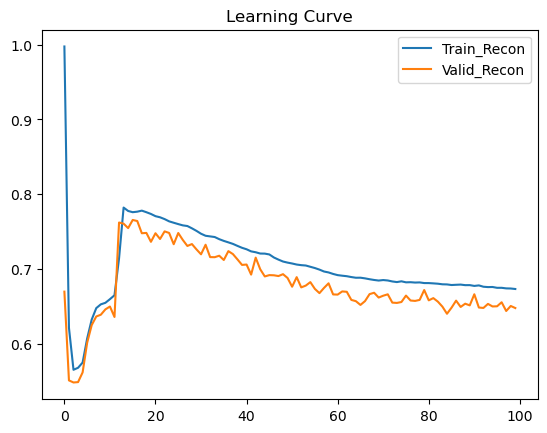

In [27]:
plt.plot(train_losses.get(), label='Train_Recon')
plt.plot(valid_losses.get(), label='Valid_Recon')
# plt.plot(train_kl_losses.get(), label='Train_KL')
# plt.plot(valid_kl_losses.get(), label='Valid_KL')
plt.legend()
plt.title('Learning Curve')

In [29]:
l_reconstruct, l_embedding, l_commitment

(tensor(0.2704, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3098, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3098, device='cuda:0', grad_fn=<DivBackward0>))

基本上Valid Loss稳定了(其实还有下降空间). 同时要保存在验证集上结果最好的模型, 因为等会还要用最好的模型做生成.

In [30]:
ts

'0218230825'